<a href="https://www.kaggle.com/code/samyabose/stock-price-forecasting?scriptVersionId=98622248" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Stock Price Forcasting Using LSTM
---
## Problem Statement ~
> In project, we will be talking about predicting the returns on stocks. This is a very complex task and has uncertainties. You need to develop a model that will learn how to predict stock price using the LSTM neural network.

### Dataset
> The dataset for this project is available on Kaggle. 

**Link:** https://www.kaggle.com/datasets/ishaandhull/tata-set

### Table of Contents¶
#### 1. Environment Setup
#### 2. Dataset Gathering
#### 3. Exploratory Data Analysis
#### 4. Dataset Preprocessing
#### 5. Model Evaluation
#### 6. Performance Measurement

# 1. Environment Setup:
---
> In this step, we have installed and imported all neccessary libraries required to proceed with the solution to the given problem statement.

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 2. Dataset Gathering
---
> In this step, we have gathered the dataset from kaggle and have verified its integrity.

In [2]:
df=pd.read_csv("../input/tata-set/NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


# 3. Exploratory Data Analysis
---
> In this step, we took a deeper look at the data, and checked if the data is properly gathered in the previous steps.

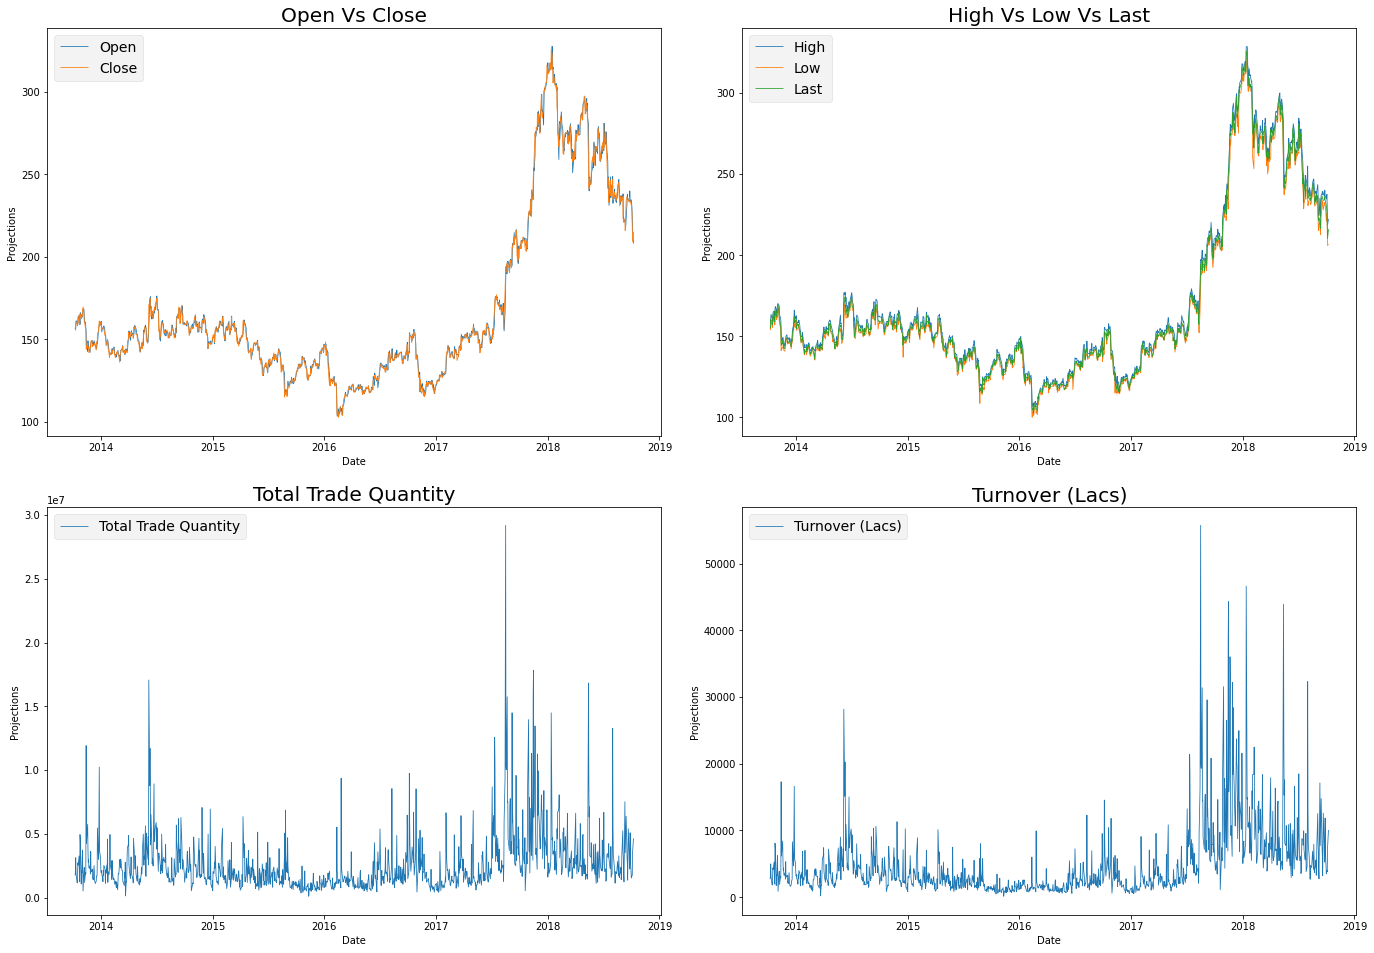

In [4]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20, 14), squeeze=False)
fig.tight_layout(pad=5)
plt.style.use('fivethirtyeight')

# Graph for Open and Close
axes[0][0].plot(df["Open"],linewidth=0.8)
axes[0][0].plot(df["Close"],linewidth=0.8)
axes[0][0].set_ylabel("Projections")
axes[0][0].set_xlabel("Date")
axes[0][0].set_title('Open Vs Close')
axes[0][0].legend(['Open', 'Close'], loc='upper left')

# Graph for High, Low and Last
axes[0][1].plot(df["High"],linewidth=0.8)
axes[0][1].plot(df["Low"],linewidth=0.8)
axes[0][1].plot(df["Last"],linewidth=0.8)
axes[0][1].set_ylabel("Projections")
axes[0][1].set_xlabel("Date")
axes[0][1].set_title('High Vs Low Vs Last')
axes[0][1].legend(['High', 'Low', 'Last'], loc='upper left')

# Graph for Total Trade Quantity
axes[1][0].plot(df["Total Trade Quantity"],linewidth=0.8)
axes[1][0].set_ylabel("Projections")
axes[1][0].set_xlabel("Date")
axes[1][0].set_title('Total Trade Quantity')
axes[1][0].legend(['Total Trade Quantity'], loc='upper left')

# Graph for Turnover (Lacs)
axes[1][1].plot(df["Turnover (Lacs)"],linewidth=0.8)
axes[1][1].set_ylabel("Projections")
axes[1][1].set_xlabel("Date")
axes[1][1].set_title('Turnover (Lacs)')
axes[1][1].legend(['Turnover (Lacs)'], loc='upper left')

# 4. Data Preprocessing:
---
> In this step, we have cleaned the data thus obtained for the previous steps before splitting them into training and testing datasets.

In [5]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
new_dataset.head()

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45


#### Normalizing the new filtered dataset
> In this step, we got rid of the unnecessary redundant bits of information from the dataset.

In [6]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis='columns',inplace=True)
final_dataset=new_dataset.values
new_dataset.head()

,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


#### Scaling the data
> In this step, we have scaled the data using the Min-Max Scaler.

In [7]:
df=new_dataset.reset_index()['Close']
print(df)

0        155.8
1       155.55
2       160.15
3       160.05
4       159.45
         ...  
1230     230.9
1231     227.6
1232     218.2
1233     209.2
1234    215.15
Name: Close, Length: 1235, dtype: object


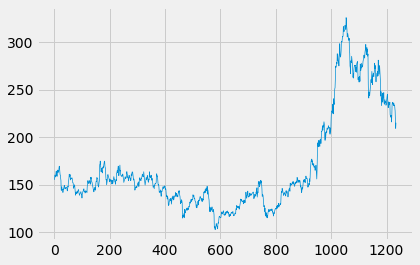

In [8]:
plt.plot(df, linewidth=0.7)

In [9]:
#Scaling the dataset
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))
print(df)

[[0.23823398]
 [0.2371134 ]
 [0.25773196]
 ...
 [0.51792918]
 [0.47758853]
 [0.50425818]]


### Splitting the dataset into Training and Testing set
> In this step, we have splitted the datset into training and testing sets, for further development.

In [10]:
training_size=int(len(df)*0.65)
testing_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

### Preprocessing the training and testing dataset
> In this step, we are performing some preprocessing the training and testing dataset.

In [11]:
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)

(701, 100)
(701,)


(None, None)

In [12]:
print(X_test.shape), print(ytest.shape)

(332, 100)
(332,)


(None, None)

In [13]:
# reshape input into a 3 dimentional array of the format [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 5. Model Evaluation:
---
> In this step, we have chosen LSTM layers for our model as it poses the most performance in problems such as these, where even a small amount of data can provide a lot of insight to the model.

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

2022-06-17 14:32:14.167298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:32:14.249302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:32:14.250185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:32:14.251444: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
____________________________________________________

In [15]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100


2022-06-17 14:32:17.193157: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-17 14:32:21.144955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


22/22 [==============================] - 6s 56ms/step - loss: 0.0049 - val_loss: 0.0551
Epoch 2/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0228
Epoch 3/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0011 - val_loss: 0.0100
Epoch 4/100
22/22 [==============================] - 0s 17ms/step - loss: 9.5221e-04 - val_loss: 0.0057
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 9.4452e-04 - val_loss: 0.0070
Epoch 6/100
22/22 [==============================] - 0s 17ms/step - loss: 8.9405e-04 - val_loss: 0.0055
Epoch 7/100
22/22 [==============================] - 0s 17ms/step - loss: 8.2621e-04 - val_loss: 0.0055
Epoch 8/100
22/22 [==============================] - 0s 17ms/step - loss: 8.6858e-04 - val_loss: 0.0034
Epoch 9/100
22/22 [==============================] - 0s 17ms/step - loss: 7.5583e-04 - val_loss: 0.0029
Epoch 10/100
22/22 [==============================] - 0s 17ms/step - loss: 7.7173e-04 - 

# 6. Performance Measurement
---
> In this step, we have evaluated the performance measure of the model.

In [16]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

Text(0.5, 1.0, 'Train Predictions')

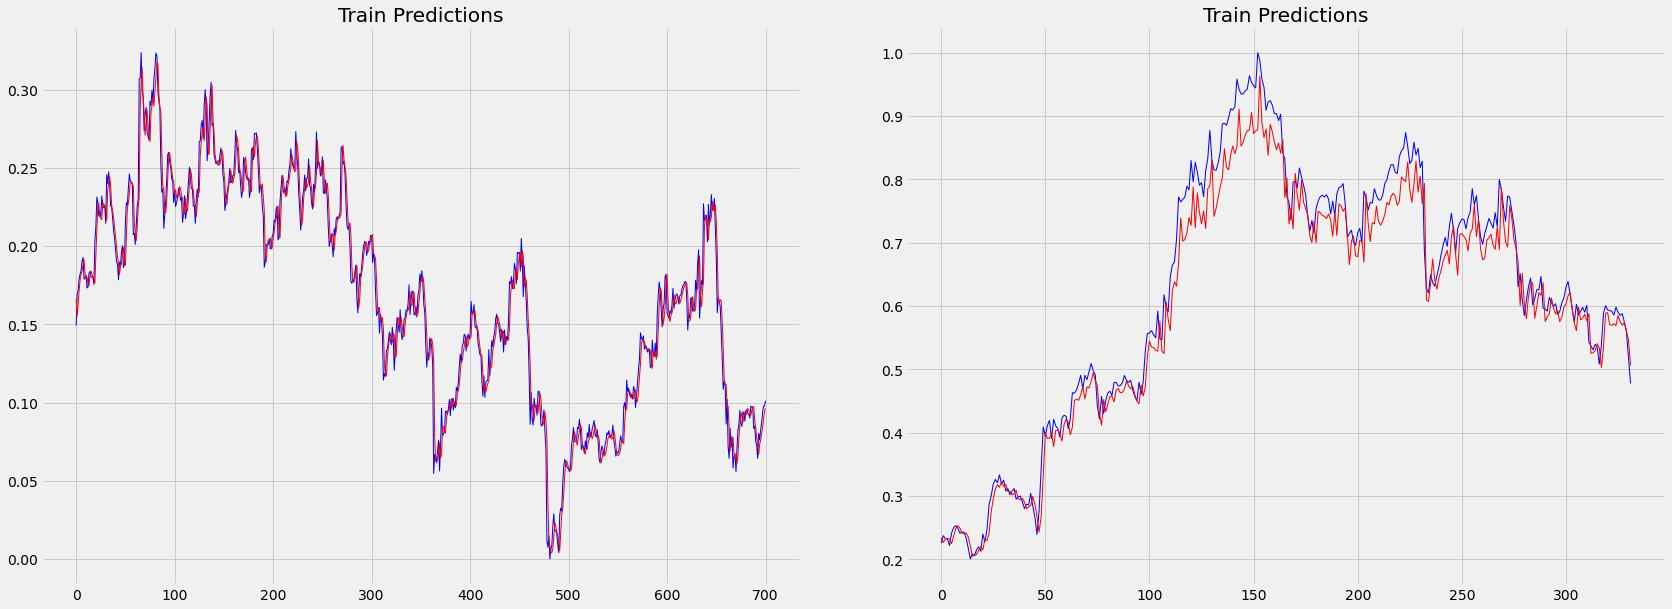

In [17]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(25, 10), squeeze=False)
fig.tight_layout(pad=5)
plt.style.use('fivethirtyeight')

# Graph for train predictions
axes[0][0].plot(y_train,color='b',linewidth=1)
axes[0][0].plot(train_predict,color='r',linewidth=1)
axes[0][0].set_title('Train Predictions')

# Graph for test predictions
axes[0][1].plot(ytest,color='b',linewidth=1)
axes[0][1].plot(test_predict,color='r',linewidth=1)
axes[0][1].set_title('Train Predictions')

In [18]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
### Calculate RMSE performance metrics for train
math.sqrt(mean_squared_error(y_train,train_predict))

140.94263266122104

In [20]:
### Test data performance metrics
mae = mean_absolute_error(ytest,test_predict)
mse = mean_squared_error(ytest,test_predict)
r2 = r2_score(ytest,test_predict)
rmse = math.sqrt(mean_squared_error(ytest,test_predict))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 235.43535891350874
MSE is 57167.14627525749
R2 is -1389587.5752669903
RMSE is 239.09652083469865


#### Plotting Predicted Results
> In this step, we have demonstrated the actual data vs the predict data in terms of the whole sequence.

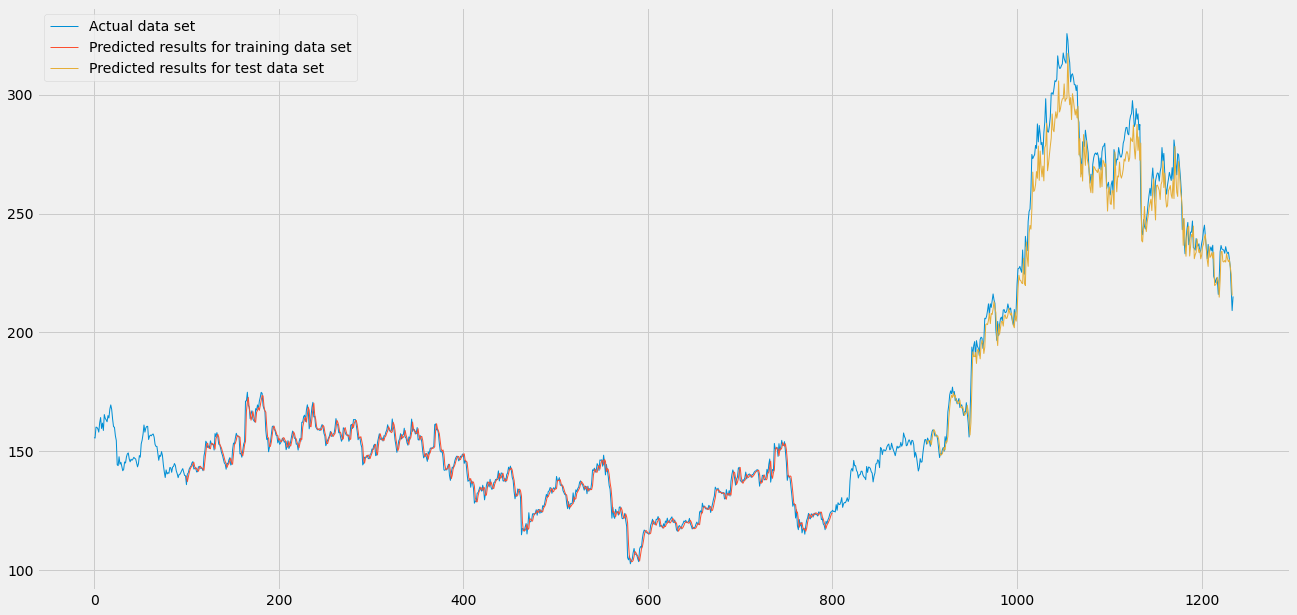

In [21]:
# Shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# Plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(df),linewidth=1)
plt.plot(trainPredictPlot,linewidth=1)
plt.plot(testPredictPlot,linewidth=1)
plt.legend(['Actual data set', 'Predicted results for training data set', 'Predicted results for test data set'], loc='upper left')
plt.show()

#### Predicting the Future Stock Price for the following Month (next 30 Days)
> In this step, we have tried to predict the stock prices for the upcoming month or next 30 days.

In [22]:
len(test_data)

433

In [23]:
#Taking the last 100 days values as input to predic future values
x_input=test_data[333:].reshape(1,-1)
x_input.shape

(1, 100)

In [24]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [25]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=1
while(i<=30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input: \n\n{}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("\n{} day output: {}\n\n\n".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

[0.50658643]
101
2 day input: 

[0.62057373 0.64926042 0.63671    0.63155536 0.64769162 0.66136262
 0.68063649 0.69565217 0.7082026  0.69408337 0.72545944 0.74652622
 0.71985657 0.68399821 0.72209771 0.7310623  0.7371134  0.73644106
 0.7218736  0.73935455 0.74831914 0.78507396 0.75974899 0.77409234
 0.73688929 0.70909906 0.69722098 0.71470193 0.72545944 0.73823398
 0.73038996 0.72299417 0.74719857 0.72523532 0.7994173  0.78283281
 0.75571493 0.73352757 0.77364411 0.77140296 0.7492156  0.72859704
 0.70035858 0.63021067 0.65105334 0.60959211 0.58471537 0.609368
 0.63043478 0.64388167 0.6017481  0.61160914 0.62572837 0.62550426
 0.64657104 0.59614523 0.59524877 0.59166293 0.61340206 0.6048857
 0.59928283 0.60354101 0.58673241 0.5912147  0.60466159 0.61272972
 0.62909009 0.63872703 0.61810847 0.59524877 0.57530255 0.60242044
 0.58583595 0.5912147  0.59771403 0.59009413 0.60085164 0.5425818
 0.53675482 0.53070372 0.53922008 0.5349619  0.50806813 0.53787539
 0.58852532 0.60040341 0.59345585 

In [26]:
print(lst_output)

[[0.5065864324569702], [0.5134013295173645], [0.5139288306236267], [0.5093942880630493], [0.5020913481712341], [0.4946228265762329], [0.48871859908103943], [0.48490530252456665], [0.48278769850730896], [0.4815593957901001], [0.48045170307159424], [0.4789869785308838], [0.47702738642692566], [0.4746832549571991], [0.47216856479644775], [0.46967753767967224], [0.4673193395137787], [0.4651110768318176], [0.4630080759525299], [0.4609447717666626], [0.45886725187301636], [0.45674824714660645], [0.4545872211456299], [0.45240092277526855], [0.45021140575408936], [0.4480375051498413], [0.4458903968334198], [0.44377401471138], [0.44168755412101746], [0.439628541469574]]


In [27]:
print("The output for the upcoming 30 days is :")
print(scaler.inverse_transform(lst_output))

The output for the upcoming 30 days is :
[[215.66943308]
 [217.18983662]
 [217.30752211]
 [216.29586567]
 [214.66657978]
 [213.00035261]
 [211.68311945]
 [210.83237299]
 [210.35993554]
 [210.0859012 ]
 [209.83877496]
 [209.51199491]
 [209.07480991]
 [208.55183418]
 [207.99080681]
 [207.43505866]
 [206.90894465]
 [206.41628124]
 [205.94710175]
 [205.48677858]
 [205.02328389]
 [204.55053394]
 [204.06840904]
 [203.58064587]
 [203.09216462]
 [202.6071674 ]
 [202.12814753]
 [201.65598268]
 [201.19049332]
 [200.7311276 ]]


#### Plotting the Future Stock Prices for the following 30 Days
> In this step, we have plotted the future stock prices as predicted for the following 30 days.

In [28]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
len(df)

1235

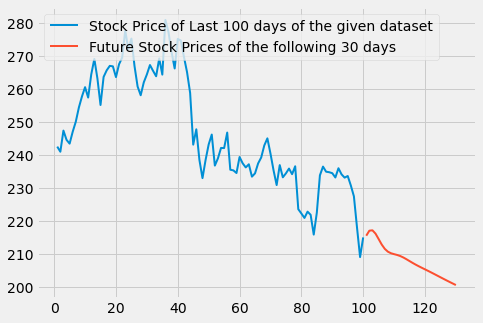

In [29]:
plt.figure(figsize=(7, 5))
plt.plot(day_new,scaler.inverse_transform(df[1135:]),linewidth=2)
plt.plot(day_pred,scaler.inverse_transform(lst_output),linewidth=2)
plt.legend(['Stock Price of Last 100 days of the given dataset', 'Future Stock Prices of the following 30 days'], loc='upper left')

#### Final Predicting Future Trend of Stock Prices
> In this step, we have finally visualized the prediction trend for the next 30 days.

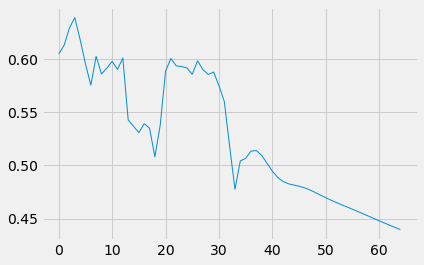

In [30]:
dframe=df.tolist()
dframe.extend(lst_output)
plt.plot(dframe[1200:],linewidth=1)